# A manual classification of dependency relations

Here, I will look into the distributive properties of a manual classification of dependency relations into two classes:

- __Content relations__: Dependencies that link a content word with another content word. 
- __Function relations__: Dependencies that link a word with a function word.

These are the relations that fit well within the specification of what I consider to be content and function dependencies. More fuzzy choices are further elaborated below.

### Content dependents

acl, advcl, advmod, amod, appos, ccomp, compound, conj, csubj, csubjpass, dislocated, dobj, iobj, list, name, nmod, nsubj, nsubjpass, nummod, parataxis, remnant, root, vocative, xcomp

### Function dependents

aux, auxpass, case, cc, cop, det, expl, mark, neg, mwe

### Others

punct, discourse, reparandum, dep, goeswith, foreign

## Motivation

### Nonsemantic dependents

__discourse__: Based on [the specification](http://universaldependencies.github.io/docs/u/dep/discourse.html) and each language's documentation, discourse seems to be used mainly for interjections, exclamations, emoticons, as well as a few language specific instances. While the [current distribution](/notebooks/Dependency%20distribution%20in%20Universal%20Dependency%20languages.ipynb) says otherwise, we would expect this to be fairly consistent across the languages. The fact that it isn't has probably more to do with treebank inconsistencies, as well as that some languages (Bulgarian) has more user generated text data. 

__reparandum__: Almost exclusively used in English. I expect this to rise in usage with speech treebanks becoming increasingly more common. This would be an important relation when comparing such treebanks. That said, there is no content information found in this relation.

__dep__: _unspecified dependency_ -- this is the goto dependency in cases where the parser cannot make a better guess about its relation. In theory, based on [its description](http://universaldependencies.github.io/docs/u/dep/dep.html), I would presume that the relation would only be available in the parser output. That said, looking at the [dependency distribution](/notebooks/Dependency%20distribution%20in%20Universal%20Dependency%20languages.ipynb), we can see that it is quite present in most notably Danish.  If it was the case that it was only in the parser output, its content/function classification wouldn't make any difference since we would use the gold standard as the main reference to compare the output against. In practice, though, that doesn't seem to be the case. Since we cannot assume any syntactic information on the relations, we will choose to ignore it.

__goeswith__: Almost exclusively used in English and Danish. We cannot make any assumptions about its syntatic information, and is of little significance (in my opinion) when evaluating the quality of the parser. 


### Function dependents


__mwe__: multi-word expressions are idiomatically coded expressions, often between function words with our without a content word. Since the word order often is quite strict, and [some](http://universaldependencies.github.io/docs/en/dep/mwe.html) [languages](http://universaldependencies.github.io/docs/fi/dep/mwe.html) even lists all(?) of them, we expect them to be fairly easy to parse and give big benefits for languages with many such relations.


### Found quirks

__compound__: German tokenizes e.g. _T-shirt_ into _T_, _\-\-_, and _shirt_ with a compound relation between _shirt_ and _T_, while Swedish keeps it as one token. This causes German to have quite a few more compound relations than similar languages. (1114 in German training data, 6 in Swedish).

# Distribution of function dependents

In [14]:
function_relations = ['aux', 'auxpass', 'case', 'cc', 'cop', 'det', 'expl', 'mark', 'neg', 'mwe']

In [15]:
%matplotlib inline
import matplotlib
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.style.use('ggplot')

treebank_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-1/ud-treebanks-v1.1"

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../tools/')
import udtree

import pandas as pd
import seaborn as sns

from os import listdir
from os.path import join
from collections import defaultdict
from scipy.stats import entropy
# Languages ordered according to their sTTR score (see other notebook for how).
sttr_order = pd.DataFrame.from_csv('../data/standard_ttr.1.1.csv').index


# Extract treebank paths. Lists are necessary since Czech has multiple files.
train_files = {'UD_Basque': ['eu-ud-train.conllu'], 
              'UD_Croatian': ['hr-ud-train.conllu'], 
              'UD_Danish': ['da-ud-train.conllu'], 
              'UD_Finnish': ['fi-ud-train.conllu'], 
              'UD_French': ['fr-ud-train.conllu'], 
              'UD_Greek': ['el-ud-train.conllu'], 
              'UD_Hungarian': ['hu-ud-train.conllu'], 
              'UD_Irish': ['ga-ud-train.conllu'], 
              'UD_Persian': ['fa-ud-train.conllu'], 
              'UD_Swedish': ['sv-ud-train.conllu'], 
              'UD_Bulgarian': ['bg-ud-train.conllu'], 
              'UD_Czech': ['cs-ud-train-c.conllu',
                           'cs-ud-train-m.conllu',
                           'cs-ud-train-v.conllu',
                           'cs-ud-train-l.conllu'], 
              'UD_English': ['en-ud-train.conllu'], 
              'UD_Finnish-FTB': ['fi_ftb-ud-train.conllu'], 
              'UD_German': ['de-ud-train.conllu'], 
              'UD_Hebrew': ['he-ud-train.conllu'], 
              'UD_Indonesian': ['id-ud-train.conllu'], 
              'UD_Italian': ['it-ud-train.conllu'], 
              'UD_Spanish': ['es-ud-train.conllu']}

# UD_Language: [filepaths]
treebanks = {f: [join(treebank_path, f, train_file) for train_file in train_files[f]]
             for f in listdir(treebank_path) 
             if f.startswith("UD_")}  # remove hidden files


def sum_deprels(trees):
    deprels = defaultdict(int)
    for tree in trees:
        for deprel in tree.deprels:
            # Ignoring language specific labels
            deprels[deprel.split(":")[0]] += 1
    return deprels

df_dict = {}
for language, treebank in treebanks.items():
    deprels = sum_deprels(udtree.from_files(treebank))
    df_dict[language] = deprels

deprel_per_lang = pd.DataFrame.from_dict(df_dict).transpose()

# Language ratio of function dependents

The ratio of function dependencies for each language. They seem to be especially common in roman languages. Luckily, we find Finnish at the bottom just as expected.

In [16]:
function_dist = deprel_per_lang.div(deprel_per_lang.sum(axis=1), axis=0).fillna(0)[function_relations]
language_function_ratio = function_dist.sum(axis=1).sort_values(ascending=False)
language_function_ratio

UD_Italian        0.408116
UD_French         0.390764
UD_Spanish        0.383768
UD_Greek          0.360893
UD_Hebrew         0.351597
UD_German         0.350782
UD_Swedish        0.317893
UD_Irish          0.314652
UD_English        0.307499
UD_Bulgarian      0.292409
UD_Persian        0.291038
UD_Danish         0.257477
UD_Croatian       0.245975
UD_Hungarian      0.224475
UD_Czech          0.204860
UD_Indonesian     0.200521
UD_Basque         0.198162
UD_Finnish-FTB    0.169289
UD_Finnish        0.142833
dtype: float64

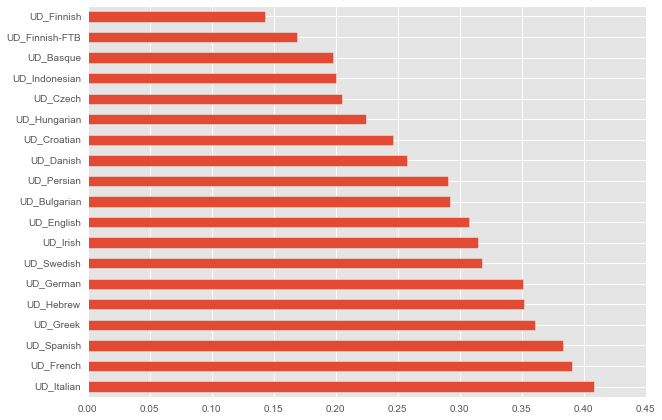

In [17]:
language_function_ratio.plot(kind='barh')

## Heatmap of function dependents

The languages are sorted according to the sTTR previously calculated. We can see that especially _det_, and _case_ are much more commonly used among the more isolated languages. It's a bit more difficult to say anything about the others.

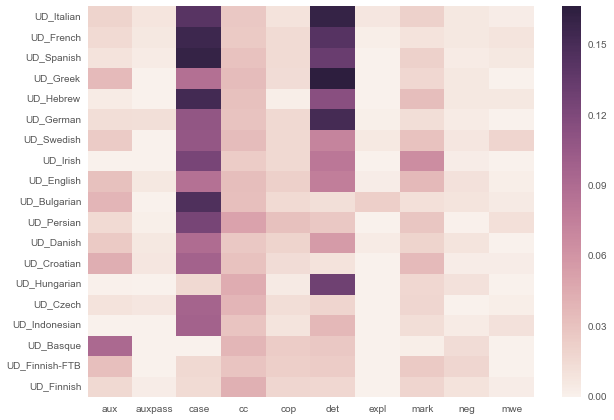

In [18]:
sns.heatmap(function_dist.ix[language_function_ratio.index])

## Correlation between ratio of function dependents and the standard type-token ratio

If the function distribution and the sTTR have a strong correlation, I would say we have a pretty strong motivation of our choice of relations.

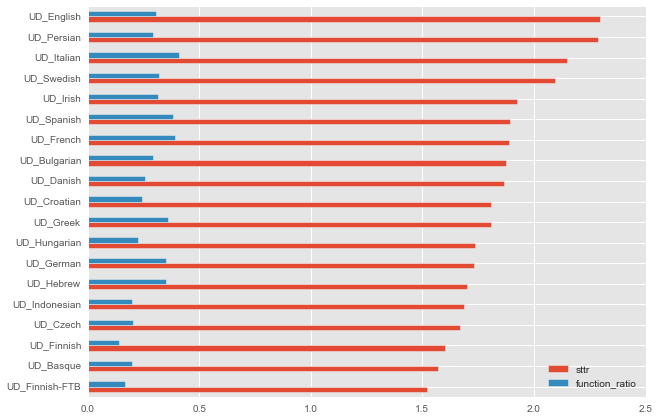

In [19]:
sttr = pd.DataFrame.from_csv('../data/standard_ttr.1.1.csv')['mean']
sttr_function_ratio = pd.concat([sttr, language_function_ratio], axis=1)
sttr_function_ratio.columns = ['sttr', 'function_ratio']
sttr_function_ratio.sort_values('sttr').plot(kind='barh')

In [20]:
sttr_function_ratio.sort_values('sttr').corr('pearson')

,sttr,function_ratio
sttr,1.000000,0.565349
function_ratio,0.565349,1.000000


# Problems

English is quite a lot further down than I would like it to be.